<a href="https://colab.research.google.com/github/xsinxxer/starters/blob/main/ai_explainability_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#First we're making a cat-dog classification model to show model interpretation on complex cnn models

# Accessing from Kaggle

In [5]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = ':https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F3362%2F31148%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240528%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240528T123021Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D7077a1bb3bb3bdc7e5a317e187c80e96f7e90b3b975d3136d62649d82e46fecf547e3c37e62de8eac82342ccbb5dc8676c233ec0eac15138215cfb2706464a142f6013b24c8e0d85df0d764d33809d3e62d0120a755b300328d699eadc5c5975bc1384f4f1489a19f1b49afefc953fdc708bb8532741e6009cf78c55964c6f0802442feb061f4b2424edb365f1647691e3125c5cd13d5c6211785f1189fdc7b96df2f399a2533d75a9d79264d1c5ae44bc63bc986400ee1e1b13735ca76677191ce20aabb2d11c9e118300d60a0947d50afa939a18c08b99c8564259bcdcf71a94bb2581fabfaaa920efb6a83818f1440c62c36eef3c5f7e8cf59d6af8714d44'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 851576689 bytes downloaded
Downloaded and uncompressed: 
Data source import complete.


# Import Library

In [6]:
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator, load_img  #.image
from keras.utils import to_categorical  #from.utils!!
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt #matplot
import random
import os
print(os.listdir("../input"))


['test1.zip', 'sampleSubmission.csv', 'train.zip']


In [7]:
FAST_RUN = False
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

In [8]:
import zipfile
import os
def extract_zip(zip_file, extract_to):
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
zip_file_path = '../input/train.zip'

extract_to_path = '../input/'
if os.path.exists(zip_file_path):
    extract_zip(zip_file_path, extract_to_path)
    print("Extraction complete.")
else:
    print("The specified zip file does not exist.")


Extraction complete.


In [9]:
print(os.listdir("../input"))

['test1.zip', 'sampleSubmission.csv', 'train', 'train.zip']


# Prepare Traning Data

In [10]:
filenames = os.listdir("../input/train")
categories = []
for filename in filenames:
    category = filename.split('.')[0] #just stores strings; moreover by splitting
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [11]:
df.head()

filename  category
0  cat.5836.jpg         0
1  cat.8227.jpg         0
2  dog.4460.jpg         1
3  dog.7558.jpg         1
4  dog.9285.jpg         1

In [12]:
df.tail()

filename  category
24995   dog.2527.jpg         1
24996  cat.12045.jpg         0
24997   dog.2983.jpg         1
24998   cat.1588.jpg         0
24999   dog.3351.jpg         1

### See Total In count

<Axes: xlabel='category'>

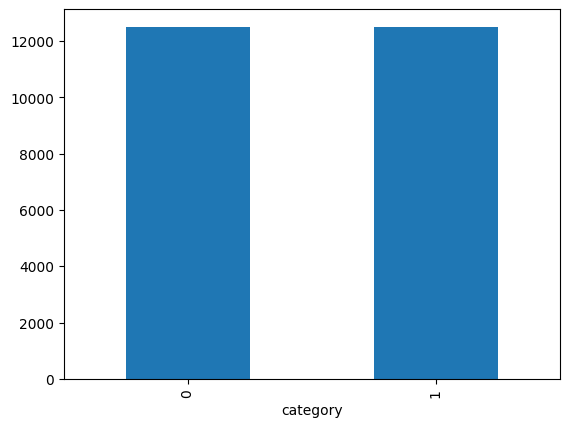

In [13]:
df['category'].value_counts().plot.bar()  #has the option of .plot.and .bar(); plot is object

From our data we have 12000 cats and 12000 dogs

# See sample image

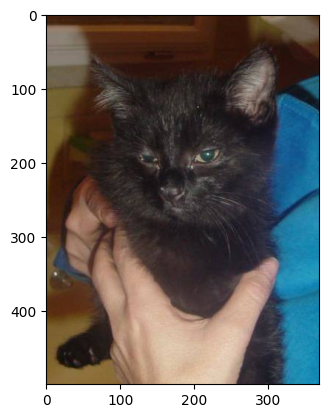

In [14]:
sample = random.choice(filenames)
image = load_img("../input/train/"+sample)#load_image from keras
plt.imshow(image)#and imshow accepst numpy,tf and even keras imagload

# Build Model

<img src="https://i.imgur.com/ebkMGGu.jpg" width="100%"/>

* **Input Layer**: It represent input image data. It will reshape image into single diminsion array. Example your image is 64x64 = 4096, it will convert to (4096,1) array.
* **Conv Layer**: This layer will extract features from image.
* **Pooling Layer**: This layerreduce the spatial volume of input image after convolution.
* **Fully Connected Layer**: It connect the network from a layer to another layer
* **Output Layer**: It is the predicted values layer.

In [15]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))#input_shape
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())#batch with brackets
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 126, 126, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 63, 63, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 61, 61, 64)        2

# Callbacks

In [12]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

**Early Stop**

To prevent over fitting we will stop the learning after 10 epochs and val_loss value not decreased

In [13]:
earlystop = EarlyStopping(patience=10)#object this way!!

**Learning Rate Reduction**

We will reduce the learning rate when then accuracy not increase for 2 steps

In [14]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',
                                            patience=2,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

In [15]:
callbacks = [earlystop, learning_rate_reduction]

# Prepare data

Because we will use image genaretor `with class_mode="categorical"`. We need to convert column category into string. Then imagenerator will convert it one-hot encoding which is good for our classification.

So we will convert 1 to dog and 0 to cat

In [16]:
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'})#.replace of df only as function!!!

In [17]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

<Axes: xlabel='category'>

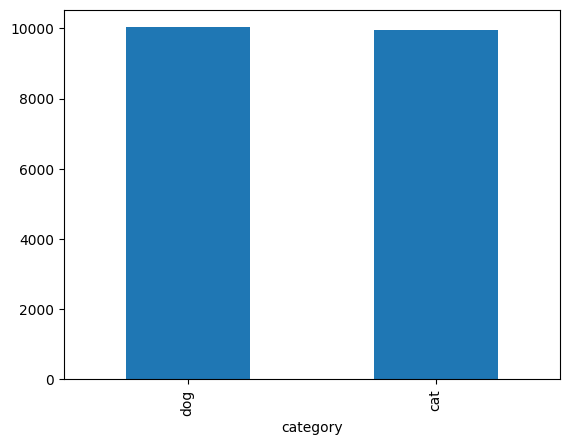

In [18]:
train_df['category'].value_counts().plot.bar()

<Axes: xlabel='category'>

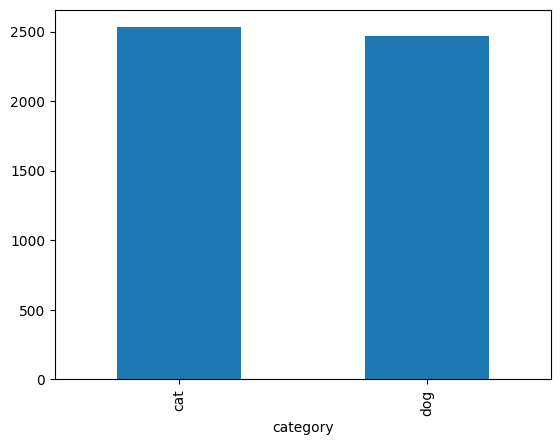

In [19]:
validate_df['category'].value_counts().plot.bar()

In [18]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

# Traning Generator

In [19]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)#specifies just parameters

train_generator = train_datagen.flow_from_dataframe(#.flow
    train_df,
    "../input/train/",
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size#doesnt understnds
)

Found 20000 validated image filenames belonging to 2 classes.


### Validation Generator

In [20]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df,
    "../input/train/",
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 5000 validated image filenames belonging to 2 classes.


# See how our generator work

In [21]:
example_df = train_df.sample(n=1).reset_index(drop=True)#for n=1 generates atm
example_generator = train_datagen.flow_from_dataframe(
    example_df,
    "../input/train/",
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


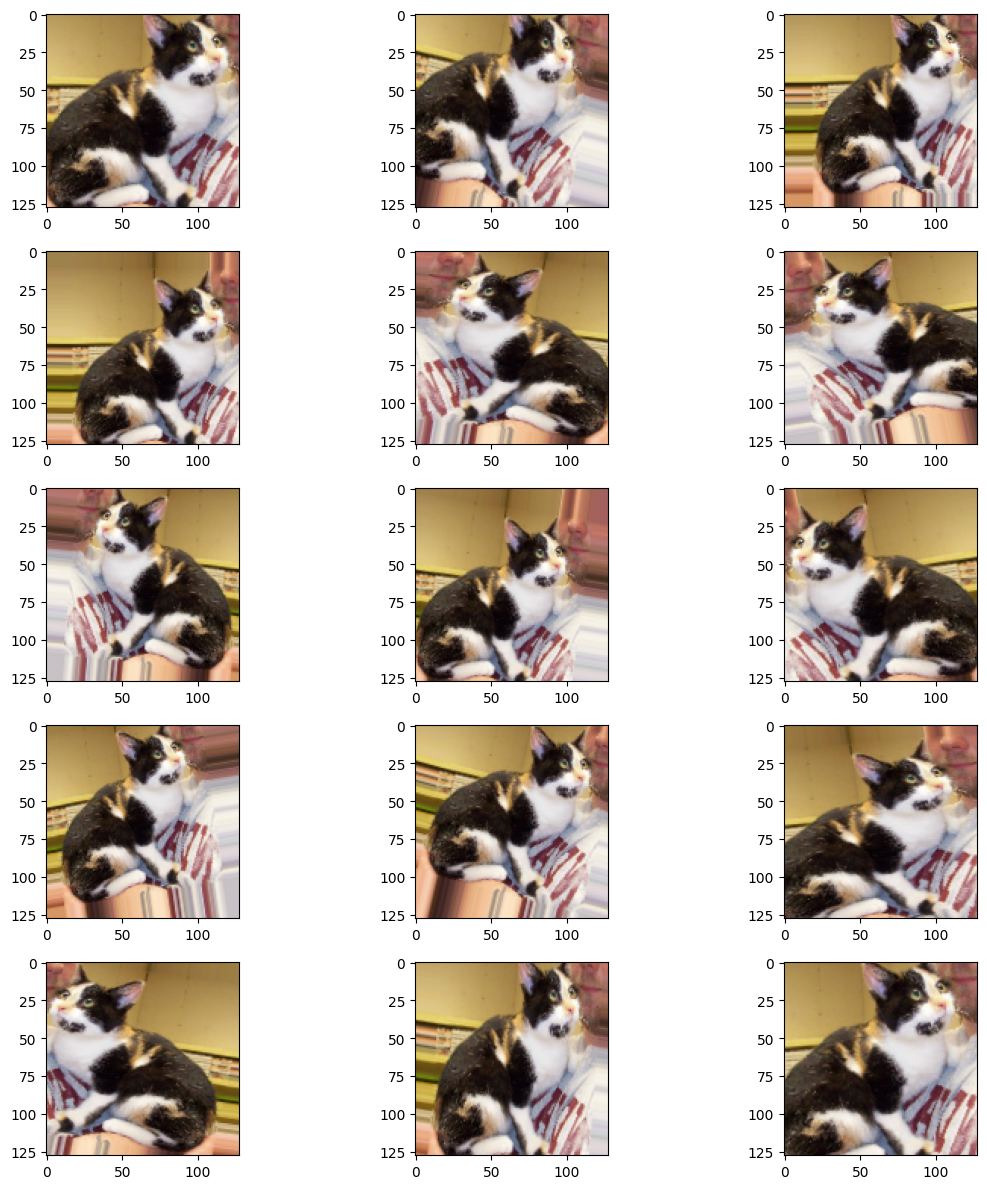

In [22]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:#a batch with variants inside
    #better to keep all this one one batch than sparse setting!!!!!!!!
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

Seem to be nice

# Fit Model

In [25]:
epochs=3 if FAST_RUN else 50
history = model.fit_generator(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

Epoch 1/50


<ipython-input-25-035bd47b0476>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


1333/1333 [==============================] - ETA: 0s - loss: 0.7410 - accuracy: 0.6342

1333/1333 [==============================] - 141s 100ms/step - loss: 0.7410 - accuracy: 0.6342 - val_loss: 1.9534 - val_accuracy: 0.5510 - lr: 0.0010
Epoch 2/50
1333/1333 [==============================] - ETA: 0s - loss: 0.5625 - accuracy: 0.7165

1333/1333 [==============================] - 126s 94ms/step - loss: 0.5625 - accuracy: 0.7165 - val_loss: 0.5528 - val_accuracy: 0.7495 - lr: 0.0010
Epoch 3/50
1333/1333 [==============================] - ETA: 0s - loss: 0.5089 - accuracy: 0.7607

1333/1333 [==============================] - 129s 97ms/step - loss: 0.5089 - accuracy: 0.7607 - val_loss: 0.7274 - val_accuracy: 0.6985 - lr: 0.0010
Epoch 4/50
1333/1333 [==============================] - ETA: 0s - loss: 0.4743 - accuracy: 0.7799

1333/1333 [==============================] - 145s 109ms/step - loss: 0.4743 - accuracy: 0.7799 - val_loss: 0.4140 - val_accuracy: 0.8120 - lr: 0.0010
Epoch 5/50
1333/1333 [==============================] - ETA: 0s - loss: 0.4513 - accuracy: 0.7916

1333/1333 [==============================] - 159s 119ms/step - loss: 0.4513 - accuracy: 0.7916 - val_loss: 0.3868 - val_accuracy: 0.8206 - lr: 0.0010
Epoch 6/50
1333/1333 [==============================] - ETA: 0s - loss: 0.4274 - accuracy: 0.8052

1333/1333 [==============================] - 125s 94ms/step - loss: 0.4274 - accuracy: 0.8052 - val_loss: 0.3170 - val_accuracy: 0.8703 - lr: 0.0010
Epoch 7/50
1333/1333 [==============================] - ETA: 0s - loss: 0.4133 - accuracy: 0.8150

1333/1333 [==============================] - 124s 93ms/step - loss: 0.4133 - accuracy: 0.8150 - val_loss: 0.4159 - val_accuracy: 0.8030 - lr: 0.0010
Epoch 8/50
1333/1333 [==============================] - ETA: 0s - loss: 0.3937 - accuracy: 0.8244

1333/1333 [==============================] - 124s 93ms/step - loss: 0.3937 - accuracy: 0.8244 - val_loss: 0.2808 - val_accuracy: 0.8841 - lr: 0.0010
Epoch 9/50
1333/1333 [==============================] - ETA: 0s - loss: 0.3807 - accuracy: 0.8335

1333/1333 [==============================] - 127s 95ms/step - loss: 0.3807 - accuracy: 0.8335 - val_loss: 0.3268 - val_accuracy: 0.8649 - lr: 0.0010
Epoch 10/50
1333/1333 [==============================] - ETA: 0s - loss: 0.3696 - accuracy: 0.8390

1333/1333 [==============================] - 123s 92ms/step - loss: 0.3696 - accuracy: 0.8390 - val_loss: 0.3375 - val_accuracy: 0.8575 - lr: 0.0010
Epoch 11/50
1333/1333 [==============================] - ETA: 0s - loss: 0.3693 - accuracy: 0.8377

1333/1333 [==============================] - 127s 95ms/step - loss: 0.3693 - accuracy: 0.8377 - val_loss: 0.3339 - val_accuracy: 0.8681 - lr: 0.0010
Epoch 12/50
1333/1333 [==============================] - ETA: 0s - loss: 0.3598 - accuracy: 0.8429

1333/1333 [==============================] - 124s 93ms/step - loss: 0.3598 - accuracy: 0.8429 - val_loss: 0.3053 - val_accuracy: 0.8817 - lr: 0.0010
Epoch 13/50
1333/1333 [==============================] - ETA: 0s - loss: 0.3525 - accuracy: 0.8478

1333/1333 [==============================] - 126s 95ms/step - loss: 0.3525 - accuracy: 0.8478 - val_loss: 0.3744 - val_accuracy: 0.8424 - lr: 0.0010
Epoch 14/50
1333/1333 [==============================] - ETA: 0s - loss: 0.3497 - accuracy: 0.8467

1333/1333 [==============================] - 126s 94ms/step - loss: 0.3497 - accuracy: 0.8467 - val_loss: 0.3154 - val_accuracy: 0.8617 - lr: 0.0010
Epoch 15/50
1333/1333 [==============================] - ETA: 0s - loss: 0.3447 - accuracy: 0.8528

1333/1333 [==============================] - 123s 92ms/step - loss: 0.3447 - accuracy: 0.8528 - val_loss: 0.4251 - val_accuracy: 0.8128 - lr: 0.0010
Epoch 16/50
1333/1333 [==============================] - ETA: 0s - loss: 0.3388 - accuracy: 0.8548

1333/1333 [==============================] - 124s 93ms/step - loss: 0.3388 - accuracy: 0.8548 - val_loss: 0.3008 - val_accuracy: 0.8781 - lr: 0.0010
Epoch 17/50
 156/1333 [==>...........................] - ETA: 1:44 - loss: 0.3202 - accuracy: 0.8607

KeyboardInterrupt: 

# Achieved 85% around accuracy, now lets save the model first

In [26]:
model.save_weights("model.h5")

#Accessing/Loading model

In [61]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))
# Compile the model (same as before)
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model.load_weights("/content/model.h5")
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 batch_normalization_12 (Ba  (None, 126, 126, 32)      128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 63, 63, 32)        0         
 g2D)                                                            
                                                                 
 dropout_12 (Dropout)        (None, 63, 63, 32)        0         
                                                                 
 conv2d_10 (Conv2D)          (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_13 (Ba  (None, 61, 61, 64)       

# Testing

In [33]:
print(os.listdir("../input/train/"))

['cat.5836.jpg', 'cat.8227.jpg', 'dog.4460.jpg', 'dog.7558.jpg', 'dog.9285.jpg', 'cat.6935.jpg', 'dog.3127.jpg', 'cat.12438.jpg', 'cat.9985.jpg', 'dog.299.jpg', 'dog.1225.jpg', 'dog.11454.jpg', 'dog.4913.jpg', 'dog.4433.jpg', 'cat.9264.jpg', 'dog.5145.jpg', 'dog.7084.jpg', 'cat.4241.jpg', 'dog.11306.jpg', 'dog.7169.jpg', 'cat.10346.jpg', 'dog.8714.jpg', 'cat.6684.jpg', 'dog.9246.jpg', 'cat.11324.jpg', 'dog.10740.jpg', 'dog.7832.jpg', 'cat.3724.jpg', 'dog.7372.jpg', 'cat.2820.jpg', 'cat.9962.jpg', 'cat.11547.jpg', 'cat.9526.jpg', 'cat.4632.jpg', 'dog.11360.jpg', 'dog.5454.jpg', 'cat.476.jpg', 'cat.9924.jpg', 'cat.5073.jpg', 'dog.628.jpg', 'dog.11819.jpg', 'dog.3334.jpg', 'cat.2698.jpg', 'cat.3215.jpg', 'cat.2814.jpg', 'cat.4043.jpg', 'cat.10011.jpg', 'cat.2511.jpg', 'dog.2375.jpg', 'cat.1669.jpg', 'cat.6704.jpg', 'cat.11847.jpg', 'cat.163.jpg', 'dog.3097.jpg', 'dog.5985.jpg', 'dog.2720.jpg', 'cat.12338.jpg', 'dog.1848.jpg', 'cat.11469.jpg', 'dog.6527.jpg', 'dog.9483.jpg', 'dog.2312.jpg'

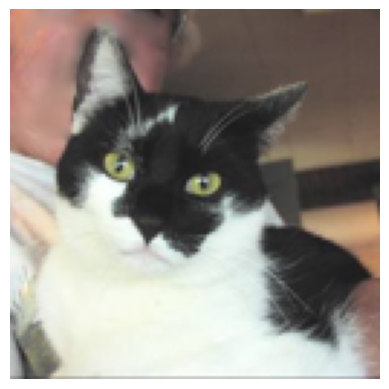

In [48]:
from PIL import Image
filename = "../input/train/cat.999.jpg"
image = Image.open(filename)
image = image.resize((128, 128))
plt.imshow(image)
plt.axis('off')#hide axes
plt.show()

In [52]:
image_array = np.array(image)
image_array=image_array/255
#print(image_array)
print(model.input)
print(model.predict(image_array.reshape(1,128,128,3)))

1/1 [==============================] - 0s 41ms/step
Prediction for ../input/train/cat.6029.jpg : [[0.98623043 0.01376952]]
1/1 [==============================] - 0s 35ms/step
Prediction for ../input/train/cat.999.jpg : [[0.9970227  0.00297731]]
1/1 [==============================] - 0s 59ms/step
Prediction for ../input/train/dog.32.jpg : [[0.07843848 0.92156154]]


#Yayyyyyyy!!!!!, working correctly

# List of Images I wanna try -

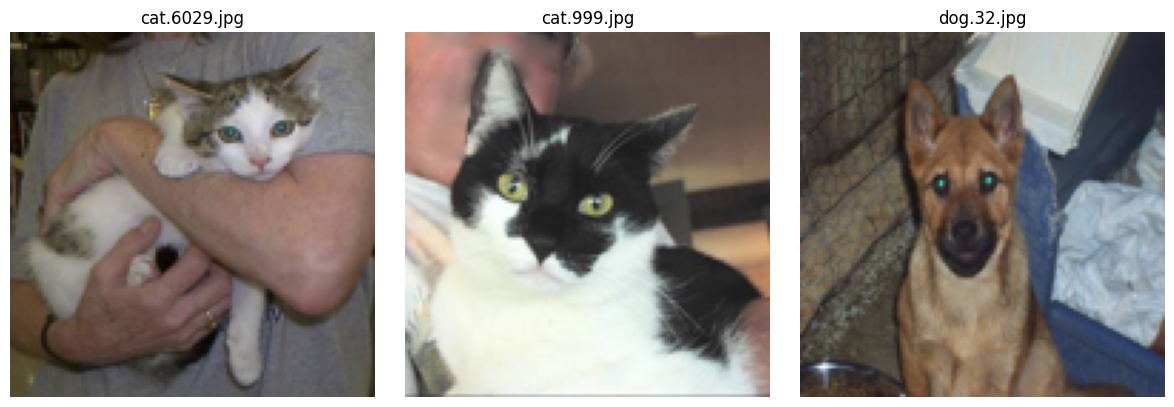

In [69]:
import matplotlib.pyplot as plt
from PIL import Image
image_paths = [
               "../input/train/cat.6029.jpg",
               "../input/train/cat.999.jpg",
               "../input/train/dog.32.jpg"]
images = []
for path in image_paths:
    image = Image.open(path)
    image = image.resize((128, 128))
    images.append(image)
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for ax, image, path in zip(axes, images, image_paths):
    ax.imshow(image)
    ax.axis('off')
    ax.set_title(path.split('/')[-1])
plt.tight_layout()
plt.show()


In [70]:
images = []
for path in image_paths:
    image = Image.open(path)
    image = image.resize((128, 128))
    image_array = np.array(image) / 255.0
    images.append(image_array)

for image, path in zip(images, image_paths):
    prediction = model.predict(image.reshape(1, 128, 128, 3))
    print("Prediction for", path, ":", prediction)

1/1 [==============================] - 0s 141ms/step
Prediction for ../input/train/cat.6029.jpg : [[0.98623043 0.01376952]]
1/1 [==============================] - 0s 34ms/step
Prediction for ../input/train/cat.999.jpg : [[0.9970227  0.00297731]]
1/1 [==============================] - 0s 46ms/step
Prediction for ../input/train/dog.32.jpg : [[0.07843848 0.92156154]]


#Vanilla gradient disappoints

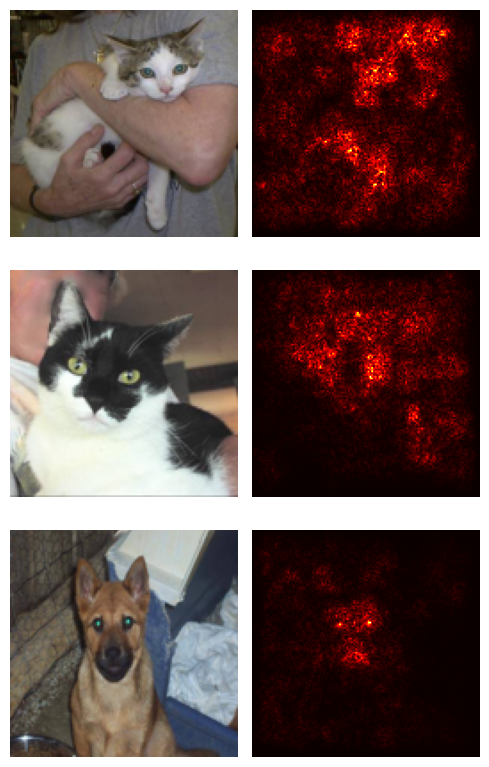

In [71]:
import tensorflow as tf

def compute_saliency(model, input_image):
    with tf.GradientTape() as tape:
        tape.watch(input_image)
        predictions = model(input_image)
        top_class = tf.argmax(predictions[0])
        top_class_output = predictions[:, top_class]

    grads = tape.gradient(top_class_output, input_image)
    saliency = tf.reduce_max(tf.abs(grads), axis=-1)
    return saliency[0]

fig, axes = plt.subplots(3, 2, figsize=(5,8))

for i, path in enumerate(image_paths):
    image = Image.open(path)
    image = image.resize((128, 128))
    image_array = np.array(image) / 255.0
    input_image = tf.convert_to_tensor(image_array[np.newaxis, ...], dtype=tf.float32)
    saliency_map = compute_saliency(model, input_image)
    axes[i, 0].imshow(image)
    axes[i, 0].axis('off')
    axes[i, 1].imshow(saliency_map, cmap='hot')
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()

In [76]:
def compute_smoothgrad(model, input_image, num_samples=50, noise_level=0.1):
    smoothgrad = np.zeros(input_image.shape[1:], dtype=np.float32)
    for i in range(num_samples):
        noise = np.random.normal(0, noise_level, input_image.shape)
        noisy_image = input_image + noise
        with tf.GradientTape() as tape:
            tape.watch(noisy_image)
            predictions = model(noisy_image)
            top_class = tf.argmax(predictions[0])
            top_class_output = predictions[:, top_class]
        grads = tape.gradient(top_class_output, noisy_image)
        grads = tf.abs(grads).numpy()
        smoothgrad += grads[0]
    smoothgrad /= num_samples
    return smoothgrad

smoothgrad_map = compute_smoothgrad(model, input_image)
smoothgrad_map = np.max(smoothgrad_map, axis=-1)
smoothgrad_map = (smoothgrad_map - smoothgrad_map.min()) / (smoothgrad_map.max() - smoothgrad_map.min())

def superimpose_heatmap(img, heatmap, alpha=0.4):
    heatmap = np.uint8(255 * heatmap)
    jet = plt.cm.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)
    return superimposed_img

# Yeah,smoothgrad does better!,below!

<ipython-input-76-1608498e68e8>:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = plt.cm.get_cmap("jet")


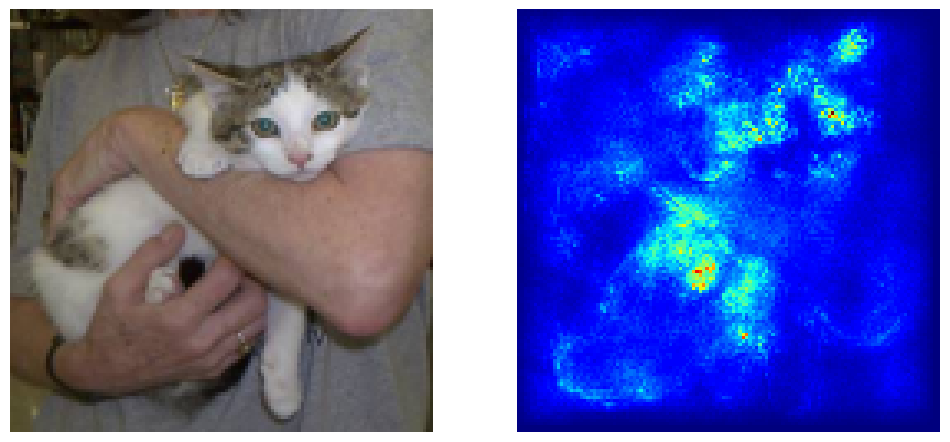

In [79]:
image_array = images[0]
input_image = tf.convert_to_tensor(image_array[np.newaxis, ...], dtype=tf.float32)
smoothgrad_map = compute_smoothgrad(model, input_image)
smoothgrad_map = np.max(smoothgrad_map, axis=-1)
smoothgrad_map = (smoothgrad_map - smoothgrad_map.min()) / (smoothgrad_map.max() - smoothgrad_map.min())
superimposed_img = superimpose_heatmap(image_array, smoothgrad_map)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(image_array)
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(superimposed_img)
plt.axis('off')
plt.show()


 #         If you notice, the model doesn't focuses on the human's hands, just the cat(where It should)

<ipython-input-76-1608498e68e8>:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = plt.cm.get_cmap("jet")


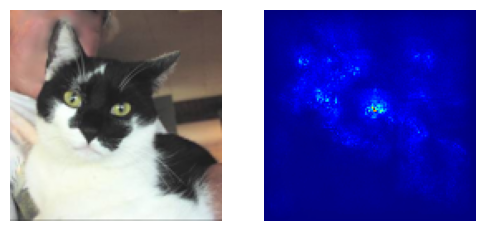

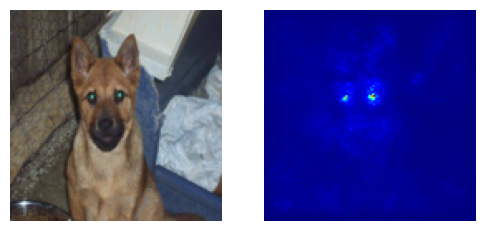

In [85]:
for image_array in images[1:]:
    input_image = tf.convert_to_tensor(image_array[np.newaxis, ...], dtype=tf.float32)
    smoothgrad_map = compute_smoothgrad(model, input_image)
    smoothgrad_map = np.max(smoothgrad_map, axis=-1)
    smoothgrad_map = (smoothgrad_map - smoothgrad_map.min()) / (smoothgrad_map.max() - smoothgrad_map.min())
    superimposed_img = superimpose_heatmap(image_array, smoothgrad_map)
    plt.figure(figsize=(6,3))
    plt.subplot(1, 2, 1)
    plt.imshow(image_array)
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(superimposed_img)
    plt.axis('off')
    plt.show()

#There's a reason model only focuses on eyes,
#because the fur texture doesn' helps much in distinguishability; but eyes do

<ipython-input-90-d3769e22319e>:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = plt.cm.get_cmap("jet")


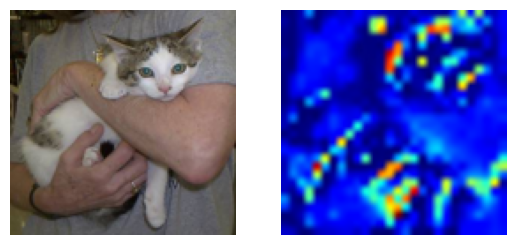

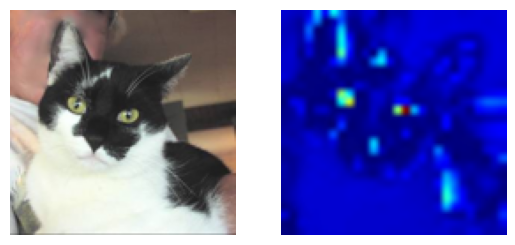

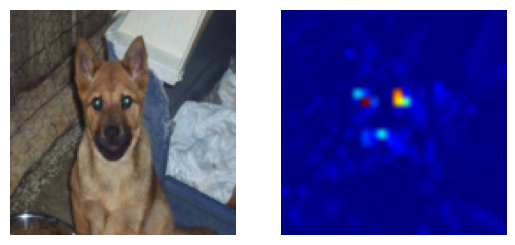

In [90]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

def make_gradcam_heatmap(model, input_image, last_conv_layer_name, pred_index=None, alpha=0.4):
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(input_image)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]
    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    heatmap = np.uint8(255 * heatmap)
    jet = plt.cm.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((input_image.shape[2], input_image.shape[1]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)
    superimposed_img = jet_heatmap * alpha + input_image[0]
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)
    return superimposed_img

for image_array in images:
    input_image = tf.convert_to_tensor(image_array[np.newaxis, ...], dtype=tf.float32)
    last_conv_layer_name = "conv2d_11"
    superimposed_img = make_gradcam_heatmap(model, input_image, last_conv_layer_name)
    plt.subplot(1, 2, 1)
    plt.imshow(image_array)
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(superimposed_img)
    plt.axis('off')
    plt.show()


# A demonstration of where ML models focus at!
#(Yellow color shows more attention, while Blue shows areas of weak to no attention)